Linear Mixed Effects Model.

In [1]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
tadpoleD1D2File = 'TADPOLE_D1_D2.csv'

data_tadpole_all = pd.read_csv(tadpoleD1D2File, low_memory=False)
data_tadpole=data_tadpole_all[['RID','D1','D2','APOE4',
                       'MMSE','DXCHANGE', 'AGE', 
                       'ADAS13','Ventricles','Hippocampus','ICV_bl','Month_bl', 'Years_bl', 'EXAMDATE']].copy()

#Create Diagnosis variable based on DXCHANGE
idx_mci=data_tadpole['DXCHANGE']==4
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_ad = data_tadpole['DXCHANGE']==5
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_ad = data_tadpole['DXCHANGE']==6
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_cn = data_tadpole['DXCHANGE']==7
data_tadpole.loc[idx_cn,'DXCHANGE']=1
idx_mci=data_tadpole['DXCHANGE']==8
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_cn = data_tadpole['DXCHANGE']==9
data_tadpole.loc[idx_cn,'DXCHANGE']=1
data_tadpole=data_tadpole.rename(columns={'DXCHANGE':'Diagnosis'})

data_tadpole['Diagnosis'] = data_tadpole.Diagnosis.astype('category')

In [3]:
import datetime as dt
data_tadpole['startdate'] = dt.datetime(2018, 1, 1)
data_tadpole['EXAMDATE'] = pd.to_datetime(data_tadpole['EXAMDATE'])

In [4]:
data_tadpole['month_to_start'] = ((data_tadpole['startdate'] - data_tadpole['EXAMDATE'])/np.timedelta64(1, 'M'))
data_tadpole['month_to_start']=data_tadpole['month_to_start'].round()

In [5]:
#correct ventricle volume
data_tadpole['Ventricles_ICV'] = data_tadpole['Ventricles'].values / data_tadpole['ICV_bl'].values

Subjects for prediction

In [6]:
#drop NaN
data_tadpole.dropna(subset = ['RID', 'Diagnosis', 'ICV_bl', 'Ventricles', 'ADAS13'],how='any',inplace=True)

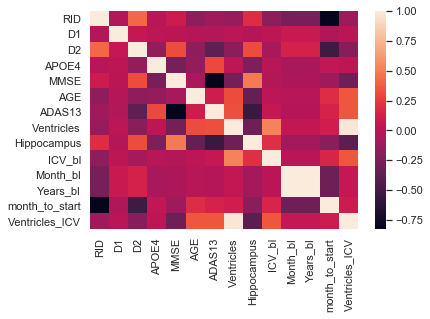

In [7]:
corr = data_tadpole.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

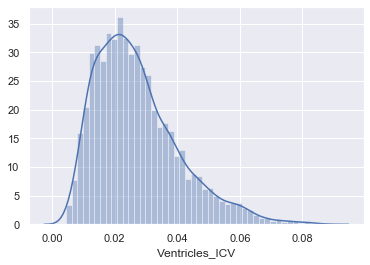

In [8]:
sns.distplot(data_tadpole.Ventricles_ICV)
plt.show()

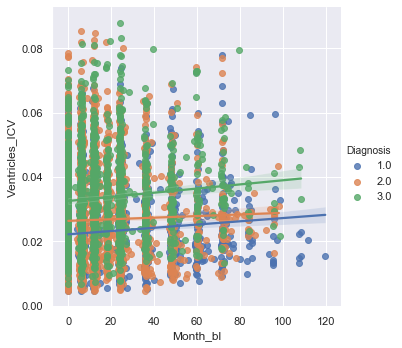

In [9]:
sns.lmplot(x = "Month_bl", y = "Ventricles_ICV", hue="Diagnosis", data = data_tadpole)

In [10]:
#Set Age for each point
data_tadpole['VISITAGE'] = data_tadpole['AGE'] + data_tadpole['Years_bl']

In [11]:
md = sm.MixedLM.from_formula("Ventricles_ICV ~ 1 + Month_bl+VISITAGE+ADAS13", re_formula="~1 + Month_bl", groups="RID", data=data_tadpole)
mdf = md.fit()
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Ventricles_ICV
No. Observations:   6611    Method:             REML          
No. Groups:         1688    Scale:              0.0000        
Min. group size:    1       Log-Likelihood:     27205.9185    
Max. group size:    11      Converged:          No            
Mean group size:    3.9                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          -0.026    0.002 -16.037 0.000 -0.029 -0.023
Month_bl            0.000    0.000  10.818 0.000  0.000  0.000
VISITAGE            0.001    0.000  30.731 0.000  0.001  0.001
ADAS13              0.000    0.000  16.456 0.000  0.000  0.000
RID Var             0.000    0.000                            
RID x Month_bl Cov  0.000    0.000                            
Month

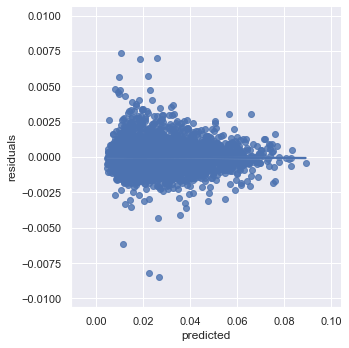

In [12]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["Month_bl"] = data_tadpole.Month_bl
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

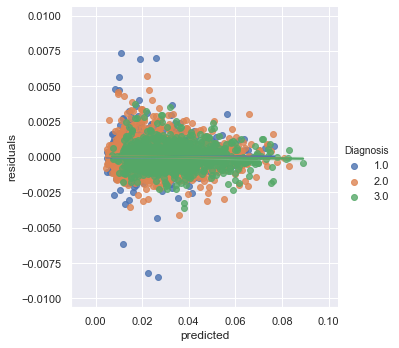

In [13]:
performance["Diagnosis"] = data_tadpole.Diagnosis
sns.lmplot(x = "predicted", y = "residuals", data = performance, hue='Diagnosis')

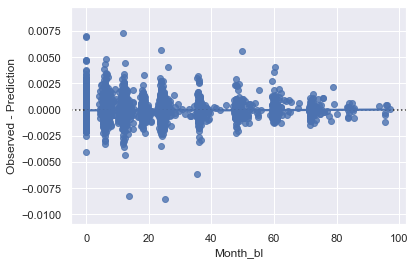

In [14]:
ax = sns.residplot(x = "Month_bl", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [15]:
# and let's store the rmse
y = mdf.resid.values
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).values.mean())

results = pd.DataFrame()
results["Method"] = ["Mixed"]
results["RMSE"] = RMSE
results

,Method,RMSE
0,Mixed,0.030083


In [16]:
print('Parameters: ', mdf.params['Month_bl'])
print('Standard errors: ', mdf.bse)
print('Predicted values: ', mdf.predict())


Parameters:  8.181789558100356e-05
Standard errors:  Intercept             0.001613
Month_bl              0.000008
VISITAGE              0.000022
ADAS13                0.000008
RID Var               0.218230
RID x Month_bl Cov    0.007870
Month_bl Var               NaN
dtype: float64
Predicted values:  [0.02653651 0.03292812 0.03361301 ... 0.03056219 0.02163338 0.02903744]


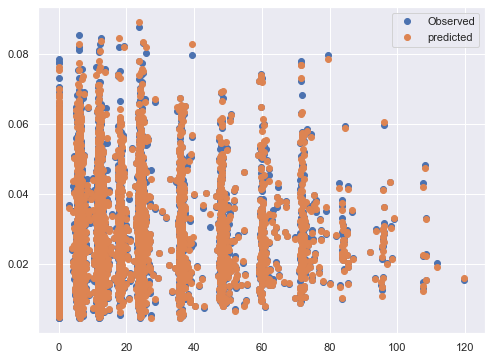

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
x=data_tadpole["Month_bl"]
ax.plot(x, data_tadpole["Ventricles_ICV"], 'o', label="Observed")
ax.plot(x, mdf.fittedvalues, 'o', label="predicted")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

In [18]:
mdf.conf_int(0.5)

,0,1
Intercept,-0.026958,-0.024782
Month_bl,0.000077,0.000087
VISITAGE,0.000656,0.000685
ADAS13,0.000132,0.000143
RID Var,9.699362,9.993750
RID x Month_bl Cov,0.082517,0.093134
Month_bl Var,NaN,NaN


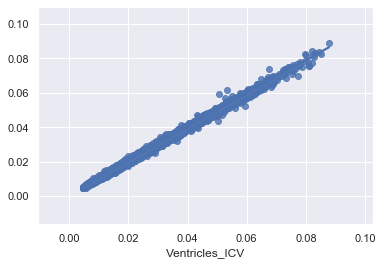

In [19]:
sns.regplot(x=data_tadpole["Ventricles_ICV"], y=mdf.fittedvalues, data=data_tadpole)

In [20]:
D2=data_tadpole['D2'].copy()
#Make list of RIDs in D2 to be predicted
idx_d2=D2==1
data_tadpole_RID = data_tadpole.loc[idx_d2,'RID']
SD2=pd.Series(np.unique(data_tadpole_RID.values))
#SD2.to_csv('ToPredict_D2.csv',index=False)

In [21]:
mdf_prediction = mdf.predict()
print(mdf_prediction)

[0.02653651 0.03292812 0.03361301 ... 0.03056219 0.02163338 0.02903744]


In [22]:
#import datetime as dt
from dateutil.relativedelta import relativedelta

# * Create arrays to contain the 60 monthly forecasts for each D2 subject
nForecasts = 5 * 12  # forecast 5 years (60 months).

# * Submission dates - compare with submission template
startDate = dt.datetime(2018, 1, 1)
endDate = startDate + relativedelta(months=+nForecasts - 1)

## Generate the very simple forecast
# * Get the list of subjects to forecast from LB2 - the ordering is the
# * same as in the submission template.
D2_SubjList = SD2
N_D2 = len(D2_SubjList)

# 1. Clinical status forecasts
#    i.e. relative likelihood of NL, MCI, and Dementia (3 numbers)
#CLIN_STAT_forecast = np.zeros([N_D2, nForecasts, 3])
# 2. ADAS13 forecasts
#    (best guess, upper and lower bounds on 50% confidence interval)
#ADAS13_forecast = np.zeros([N_D2, nForecasts, 3])
# 3. Ventricles volume forecasts
#    (best guess, upper and lower bounds on 50% confidence interval)
Ventricles_ICV_forecast = np.zeros([N_D2, nForecasts, 3])

Ventricles_ICV_forecast

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [23]:
from numpy import mean
from numpy import median
from numpy import percentile

 

# bootstrap
#dataset = result.predict()
dataset = data_tadpole["Ventricles_ICV"] #need to set to 
# configure bootstrap
n_iterations = 1000 #set low for testing
n_size = int(len(dataset) * 0.50)
total_size = int(len(dataset))

 

scores = list()
for i in range(n_iterations):
    # bootstrap sample
    sample= np.random.choice(dataset,n_size)
    # calculate and store statistic
    statistic = mean(sample)
    scores.append(statistic)
print('50th percentile (median) = %.3f' % median(scores))
# calculate 50% confidence intervals (100 - alpha)
alpha = 50.0
# calculate lower percentile (e.g. 25)
lower_p = alpha / 2.0
# retrieve observation at lower percentile
lower = max(0.0, percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))
# calculate upper percentile (e.g. 75)
upper_p = (100 - alpha) + (alpha / 2.0)
# retrieve observation at upper percentile
upper = min(1.0, percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))

50th percentile (median) = 0.027
25.0th percentile = 0.027
75.0th percentile = 0.027


In [24]:
## Now construct the forecast spreadsheet and output it.
print('Constructing the output spreadsheet {0} ...'.format('output.csv'))
submission_table = pd.DataFrame()
# * Repeated matrices - compare with submission template
submission_table['RID'] = D2_SubjList.repeat(nForecasts)
submission_table['ForecastMonth'] = np.tile(range(1, nForecasts + 1), (N_D2, 1)).flatten()

ForecastDates = [startDate]
while ForecastDates[-1] < endDate:
  ForecastDates.append(ForecastDates[-1] + relativedelta(months=+1))
ForecastDatesStrings = [dt.datetime.strftime(d, '%Y-%m') for d in ForecastDates]
submission_table['ForecastDate'] = np.tile(ForecastDatesStrings, (N_D2, 1)).flatten()
# * Pre-fill forecast data, encoding missing data as NaN
nanColumn = np.repeat(np.nan, submission_table.shape[0])
#submission_table['CNRelativeProbability'] = nanColumn
#submission_table['MCIRelativeProbability'] = nanColumn
#submission_table['ADRelativeProbability'] = nanColumn
#submission_table['ADAS13'] = nanColumn
#submission_table['ADAS1350_CILower'] = nanColumn
#submission_table['ADAS1350_CIUpper'] = nanColumn
submission_table['Ventricles_ICV'] = nanColumn
submission_table['Ventricles_ICV50_CILower'] = nanColumn
submission_table['Ventricles_ICV50_CIUpper'] = nanColumn

submission_table.rename(columns={'RID': 'RID',
                                 'ForecastMonth': 'Forecast Month',
                                 'ForecastDate': 'Forecast Date',
                                 #'CNRelativeProbability': 'CN relative probability',
                                 #'MCIRelativeProbability': 'MCI relative probability',
                                 #'ADRelativeProbability': 'AD relative probability',
                                 #'ADAS13': 'ADAS13',
                                 #'ADAS1350_CILower': 'ADAS13 50% CI lower',
                                 #'ADAS1350_CIUpper': 'ADAS13 50% CI upper',
                                 'Ventricles_ICV': 'Ventricles_ICV',
                                 'Ventricles_ICV50_CILower': 'Ventricles_ICV 50% CI lower',
                                 'Ventricles_ICV50_CIUpper': 'Ventricles_ICV 50% CI upper'}, inplace=True)
# * Write to file
submission_table.to_csv('output.csv', index=False)

Constructing the output spreadsheet output.csv ...


In [25]:
n_pred=len(mdf.predict())
data_tadpole['new_Month_bl'] = 23

y_new_pred=mdf.predict(exog=dict(Month_bl=data_tadpole['new_Month_bl'],VISITAGE=data_tadpole['VISITAGE'],ADAS13=data_tadpole['ADAS13']))

print(y_new_pred)

0        0.028418
1        0.034810
2        0.035007
3        0.036031
4        0.037068
           ...   
12370    0.026344
12386    0.026261
12408    0.028506
12428    0.019609
12484    0.026633
Length: 6611, dtype: float64


In [26]:
#empty list to hold new predictions
#from pandas import DataFrame
#column_names = ['RID',
#            'Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9',
#            'Month_10','Month_12','Month_13','Month_14','Month_15','Month_16','Month_17','Month_18','Month_19',
#            'Month_20','Month_22','Month_23','Month_24','Month_25','Month_26','Month_27','Month_28','Month_29',
#            'Month_30','Month_32','Month_33','Month_34','Month_35','Month_36','Month_37','Month_38','Month_39',
#            'Month_40','Month_42','Month_43','Month_44','Month_45','Month_46','Month_47','Month_48','Month_49',
#            'Month_50','Month_52','Month_53','Month_54','Month_55','Month_56','Month_57','Month_58','Month_59',
#            'Month_60']
#all_predictions = pd.DataFrame(columns = column_names)
#all_predictions['RID'] = [data_tadpole['RID']]

In [27]:
all_predictions = [data_tadpole['RID']]

 

forecast_month = 1
while (forecast_month < 61):
    forecast_month+=1
    data_tadpole['forecast_month']=forecast_month
    y_new_pred=mdf.predict(exog=dict(Month_bl=(data_tadpole['forecast_month']+data_tadpole['month_to_start']),VISITAGE=data_tadpole['VISITAGE'],ADAS13=data_tadpole['ADAS13']))
    all_predictions.append([y_new_pred])
print(all_predictions)

[0           2
1           3
2           3
3           3
4           3
         ... 
12370    4324
12386    4446
12408    4488
12428    4513
12484    4115
Name: RID, Length: 6611, dtype: int64, [0        0.038809
1        0.045201
2        0.044907
3        0.045440
4        0.045495
           ...   
12370    0.026508
12386    0.026425
12408    0.028588
12428    0.019691
12484    0.026714
Length: 6611, dtype: float64], [0        0.038891
1        0.045283
2        0.044988
3        0.045521
4        0.045577
           ...   
12370    0.026590
12386    0.026507
12408    0.028670
12428    0.019773
12484    0.026796
Length: 6611, dtype: float64], [0        0.038973
1        0.045364
2        0.045070
3        0.045603
4        0.045659
           ...   
12370    0.026672
12386    0.026588
12408    0.028751
12428    0.019855
12484    0.026878
Length: 6611, dtype: float64], [0        0.039055
1        0.045446
2        0.045152
3        0.045685
4        0.045741
           ...   
12370  

In [28]:
#N_Dall=len(data_tadpole['RID'])
#submission_table = pd.DataFrame()
#submission_table['RID'] = data_tadpole['RID'].values.repeat(nForecasts)
#submission_table['ForecastMonth'] = np.tile(range(1, nForecasts + 1), (N_Dall, 1)).flatten()

#ForecastDates = [startDate]
#while ForecastDates[-1] < endDate:
#  ForecastDates.append(ForecastDates[-1] + relativedelta(months=+1))
#ForecastDatesStrings = [dt.datetime.strftime(d, '%Y-%m') for d in ForecastDates]
#submission_table['ForecastDate'] = np.tile(ForecastDatesStrings, (N_Dall, 1)).flatten()


#forecast_month = 1
#while (forecast_month < 61):
#    forecast_month+=1
#    data_tadpole['forecast_month']=forecast_month
#    y_new_pred=mdf.predict(exog=dict(Month_bl=(data_tadpole['forecast_month']+data_tadpole['month_to_start']),VISITAGE=data_tadpole['VISITAGE'],ADAS13=data_tadpole['ADAS13']))
#    all_predictions.append([y_new_pred]))
#submission_table.head()

In [29]:
N_Dall=len(data_tadpole['RID'])
submission_table = pd.DataFrame()
submission_table['RID'] = data_tadpole['RID'].values.repeat(nForecasts)
submission_table['ForecastMonth'] = np.tile(range(1, nForecasts + 1), (N_Dall, 1)).flatten()

ForecastDates = [startDate]
while ForecastDates[-1] < endDate:
  ForecastDates.append(ForecastDates[-1] + relativedelta(months=+1))
ForecastDatesStrings = [dt.datetime.strftime(d, '%Y-%m') for d in ForecastDates]
submission_table['ForecastDate'] = np.tile(ForecastDatesStrings, (N_Dall, 1)).flatten()

#This should be a dataframe of all_predictions but can't seem to get it working
submission_table['Ventricles_ICV'] = y_new_pred
submission_table.head()

,RID,ForecastMonth,ForecastDate,Ventricles_ICV
0,2,1,2018-01,0.043636
1,2,2,2018-02,0.050028
2,2,3,2018-03,0.049734
3,2,4,2018-04,0.050267
4,2,5,2018-05,0.050323
